In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
from Bio.PDB import *

In [45]:
data = pd.read_csv('/Users/pressm/Documents/StatML/TCRProject/Master_file_v2.csv') #Master File Contains all PDB 

In [46]:
data_sub = data[['ID', 'Species_x','MHC_class', 'Chain','TRBV_gene','Beta', 'CDR1', 'CDR2', 'CDR3', 'Epitope']] #Select Only the necessary columns from the MasterFile
data_sub = data_sub.dropna()

In [47]:
vdjdb = pd.read_csv('/Users/pressm/Documents/StatML/TCRProject/top8antigens.csv') #Read in VDJDB Data with top 8 Antigens
vdjdb[['v.beta', 'd.beta', 'j.beta', 'cdr3.beta','antigen.epitope']]

,v.beta,d.beta,j.beta,cdr3.beta,antigen.epitope
0,TRBV6-1,NaN,TRBJ2-7,CASSEGWHSYEQYF,KLGGALQAK
1,TRBV12-5,TRBD1,TRBJ2-1,CASGLNIDGDEQFF,KLGGALQAK
2,TRBV4-3,TRBD2,TRBJ2-7,CASSPGEGLYEQYF,ELAGIGILTV
3,TRBV9,NaN,TRBJ1-6,CASSVMLDSPLHF,KLGGALQAK
4,TRBV28,TRBD1,TRBJ2-3,CASSFTYRDTQYF,KLGGALQAK
...,...,...,...,...,...
27607,TRBV27,NaN,TRBJ2-1,CASSILAGTYNEQFF,YLQPRTFLL
27608,TRBV7-9,NaN,TRBJ1-1,CASSPDIGAFF,YLQPRTFLL
27609,TRBV20-1,NaN,TRBJ2-7,CSASTDRELNEQYF,YLQPRTFLL
27610,TRBV9,NaN,TRBJ1-1,CASSVGGSEKNTEAFF,YLQPRTFLL


In [48]:
vdjdb['v.beta'].iloc[18000]

'TRBV7-8'

In [49]:
from Bio.pairwise2 import *
def get_vj_matches(db, cdr3, v_gene):
    db = db.dropna(axis = 1)
    cdr3_chains = db['CDR3']
    beta_chains = db['Beta']
    a = [align.globalxx(cdr3, chain, score_only = True) for chain in cdr3_chains] #find the best matches based on CDR3 region
    d = {'cdr3_chains':cdr3_chains, 'beta_chains':beta_chains, 'v_gene':db['TRBV_gene'], 'chains':db['Chain'], 'scores': a} # put into data frame
    df = pd.DataFrame(data = d)
    df['cdr3'] = cdr3
    df['v_gene_vdj'] = v_gene
    df = df.sort_values(by = 'scores', ascending=False, ignore_index=True)
    df = df.head(5) #get the top 5
    
    new_align = []
    for i in range(5):
        seq1 = df['beta_chains'][i]
        seq2 = df['cdr3'][i]
        alignments = align.globalms(seq1, seq2, 4, -2, -5, -.2) #find the best alignment for the cdr3 region in the dataset of betachains

        best_alignment = max(alignments, key=lambda x: x[2])
        start_idx = len(best_alignment[1].split(seq2[0])[0])
        end_idx = len(best_alignment[1]) - len(best_alignment[1].split('F')[-1]) # splice the new cdr3 into the beta chain
        new_align.append(best_alignment[0][:start_idx]+seq2 + best_alignment[0][end_idx:])
    
    df['new_align'] = new_align
    
    return df

In [50]:

all_align = pd.DataFrame() # Impute new beta chains
for i in range(8):
    epitope = np.unique(vdjdb['antigen.epitope'])[i]
    vdjdb_sub = vdjdb[vdjdb['antigen.epitope'] == epitope]
    all_new_align = pd.DataFrame()
    print(len(vdjdb_sub))
    for j in range(len(vdjdb_sub)):
        res = get_vj_matches(data_sub, vdjdb_sub['cdr3.beta'].iloc[j], vdjdb_sub['v.beta'].iloc[j])
        res['j_region'] = vdjdb_sub['j.beta'].iloc[j]
        all_new_align = pd.concat([all_new_align, res])
    all_new_align = all_new_align.reset_index(drop = True)
    all_new_align =  all_new_align[[len(align) >= 100 for align in all_new_align['new_align']]] #Don't use chains less than 100 probably not imputed correctly
    all_new_align = all_new_align[all_new_align['scores'] >= 10] #Ensure good allignment
    #all_new_align = all_new_align[all_new_align['v_gene'] == all_new_align['v_gene_vdj']] #uncomment to ensure v_genes mathc
    all_new_align = all_new_align.head(200)
    all_new_align['epitope'] = epitope
    all_new_align = all_new_align.reset_index(drop = True)
    
    all_align = pd.concat([all_align, all_new_align])

1652
1511
3949
1163
12778
4822
866
871


In [51]:
all_align = all_align.reset_index(drop = True) 

In [73]:
all_align.drop_duplicates(subset=['cdr3_chains','cdr3', 'v_gene', 'epitope'], keep='first', inplace=False)

,cdr3_chains,beta_chains,v_gene,chains,scores,cdr3,v_gene_vdj,new_align,j_region,epitope
0,CASSQGLAGAGELFF,ITQSPKYLFRKEGQNVTLSCEQNLNHDAMYWYRQDPGQGLRLIYYS...,TRBV19,B,11.0,CASSTGQATGELFF,TRBV19,ITQSPKYLFRKEGQNVTLSCEQNLNHDAMYWYRQDPGQGLRLIYYS...,TRBJ2-2,AVFDRKSDAK
1,CASSVAGTPSYEQYF,VTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFLIQY...,TRBV9,D,12.0,CASSVGGSGYEQYF,TRBV9,VTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFLIQY...,TRBJ2-7,AVFDRKSDAK
2,CASSAGTSGEYEQYF,VTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFLIQY...,TRBV9,"F,H",12.0,CASSVGGSGYEQYF,TRBV9,VTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFLIQY...,TRBJ2-7,AVFDRKSDAK
3,CASSVAVSAGTYEQYF,VTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFLIQY...,TRBV9,"F,H",12.0,CASSVGGSGYEQYF,TRBV9,VTQTPKHLITATGQRVTLRCSPRSGDLSVYWYQQSLDQGLQFLIQY...,TRBJ2-7,AVFDRKSDAK
4,CASSIRSSYEQYF,ITQSPKYLFRKEGQNVTLSCEQNLNHDAMYWYRQDPGQGLRLIYYS...,TRBV19,E,13.0,CASSIRSSYEQYF,TRBV19,ITQSPKYLFRKEGQNVTLSCEQNLNHDAMYWYRQDPGQGLRLIYYS...,TRBJ2-7,AVFDRKSDAK
...,...,...,...,...,...,...,...,...,...,...
1535,CASSRLAGGMDEQFF,VTQTPSHQVTQMGQEVILRCVPISNHLYFYWYRQILGQKVEFLVSF...,TRBV2,"E,J",10.0,CASSESSGGFFNEQFF,TRBV2,VTQTPSHQVTQMGQEVILRCVPISNHLYFYWYRQILGQKVEFLVSF...,TRBJ2-1,YLQPRTFLL
1537,CASSGLAGGMDEQFF,VTQTPSHQVTQMGQEVILRCVPISNHLYFYWYRQILGQKVEFLVSF...,TRBV2,E,10.0,CASSESSGGFFNEQFF,TRBV2,VTQTPSHQVTQMGQEVILRCVPISNHLYFYWYRQILGQKVEFLVSF...,TRBJ2-1,YLQPRTFLL
1538,CASSSWDTGELFF,VSQNPRHKITKRGQNVTFRCDPISEHNRLYWYRQTLGQGPEFLTYF...,TRBV7-9,E,10.0,CASDDPNTGELFF,TRBV7-9,VSQNPRHKITKRGQNVTFRCDPISEHNRLYWYRQTLGQGPEFLTYF...,TRBJ2-2,YLQPRTFLL
1540,CSARDLTSGANNEQFF,VSQHPSWVISKSGTSVKIECRSLDFQATTMFWYRQFPKQSLMLMAT...,TRBV20-1,"D,H",10.0,CSAHRDQNTGELFF,TRBV20-1,VSQHPSWVISKSGTSVKIECRSLDFQATTMFWYRQFPKQSLMLMAT...,TRBJ2-2,YLQPRTFLL


In [53]:
all_align.to_csv('/Users/pressm/Documents/StatML/TCRProject/1600_wVMatch_align_data.csv')

In [54]:
import seaborn as sns

<AxesSubplot: xlabel='scores', ylabel='Count'>

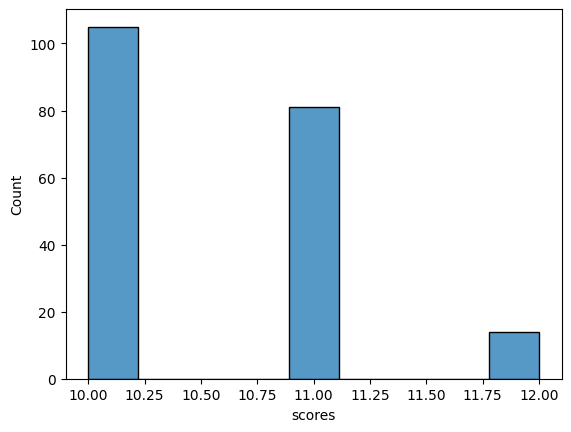

In [57]:
fig, ax = plt.subplots(1,1)
sns.histplot(all_new_align, x = 'scores', ax = ax)

In [58]:
import os
def export_fasta(filename, path, seq_name, full_seq):
    if not os.path.exists(path):
        os.mkdir(path)
    f = open(path + filename, 'w')
    f.write('>' + seq_name + '\n')
    f.write(full_seq)

In [61]:
file_type = '.fasta'
for i in range(len(all_align)): # Export newly created TCRs to fasta for prediction
    path = '/Users/pressm/Documents/StatML/TCRProject/1144_matchV_alignment/'
    filename = all_align['cdr3_chains'].iloc[i] + '_' + all_align['cdr3'].iloc[i] + '_' + all_align['v_gene'].iloc[i] + '_' + all_align['v_gene_vdj'].iloc[i]+ '_' + all_align['epitope'].iloc[i] + file_type
    path = '/Users/pressm/Documents/StatML/TCRProject/1144_matchV_alignment/'+filename.split('.')[0] + '/'
    seq_name = all_align['cdr3_chains'].iloc[i] + '_' + all_align['cdr3'].iloc[i]
    full_seq = all_align['new_align'].iloc[i]
    export_fasta(filename, path, seq_name, full_seq)

In [425]:
def export_all_in_one_fasta(filepath, seq_names, full_seqs):
    f = open(filepath, 'w')
    for idx, full_seq in enumerate(full_seqs):
        f.write('>' + seq_names[idx] + '\n')
        for i in range(len(full_seq)):
            f.write(full_seq[i])
        f.write('\n')

In [427]:
file = '/Users/pressm/Documents/StatML/TCRProject/all_seq.fasta'
seq_names = all_new_align['cdr3_chains'] + '_' + all_new_align['cdr3']
full_seqs = all_new_align['new_align']
export_all_in_one_fasta(file, seq_names, full_seqs)